In [52]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import sys
import math
import numpy as np

def set_max_recursion(num):
    sys.setrecursionlimit(num)
    
def get_input_data(filename):
    return read(filename)
    
def get_audio_data(input_data):
    audio_data = input_data[1].astype(np.int32)
    return audio_data
      
def get_rate(input_data):
    return input_data[0]

def get_time(audio_data, rate):
    return len(audio_data) / rate

def get_processed_audio_data(audio_data, rate):
    normalized_audio_data = []
    lowest_amp = input_data[1][0][0]
    for i in range(0, len(audio_data)):
        normalized_audio_data.append([i*(1/rate), audio_data[i][0]])
        if lowest_amp > audio_data[i][0]:
            lowest_amp = audio_data[i][0]
                                
    for i in range(0, len(audio_data)):
        normalized_audio_data[i][1] -= lowest_amp
        
    # print(lowest_amp)
        
    return normalized_audio_data

def draw_file(filename):
    # read audio samples
    input_data = read(filename)
    audio = input_data[1]
    # plot first 100 
    plt.plot(audio)
    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    # set the title  
    plt.title(filename)
    # display the plot
    plt.show()
    
def draw_data(audio_data):
    # plot first 100 
    plt.plot(audio_data)
    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    # set the title  
    plt.title("Hello")
    # display the plot
    plt.show()
    
def simpson(audio_data, rate, start, step):
    h = 1 / rate
    a = start
    b = start + 2 * step
    
    if (a == b): return 0
    
    return (h * (audio_data[a][1] + 4 * audio_data[a+1][1] + audio_data[a+2][1]) / 3) + simpson(audio_data, a+2, step - 1) 
    
def simpson_with_sin(a, b, w, audio_data):
    h = 1 / rate
    
    if (a + 2 >= b): return 0
    
    y0 = audio_data[a][1] * math.sin(2*math.pi*audio_data[a][0] / w)
    y1 = audio_data[a+1][1] * math.sin(2*math.pi*audio_data[a+1][0] / w)
    y2 = audio_data[a+2][1] * math.sin(2*math.pi*audio_data[a+2][0] / w)
    
    return h / 3 * (y0 + 4 * y1 + y2) + simpson_with_sin(a+2, b, w, audio_data)
    
def simpson_with_cos(a, b, w, audio_data):
    h = 1 / rate
    
    if (a + 2 >= b): return 0
    
    y0 = audio_data[a][1] * math.cos(2*math.pi*audio_data[a][0] / w)
    y1 = audio_data[a+1][1] * math.cos(2*math.pi*audio_data[a+1][0] / w)
    y2 = audio_data[a+2][1] * math.cos(2*math.pi*audio_data[a+2][0] / w)
    
    return h / 3 * (y0 + 4 * y1 + y2) + simpson_with_cos(a+2, b, w, audio_data)
    
def trapezoid(audio_data, rate, start, end):
    h = 1 / rate
    a = start
    b = end
    
    if (a == b): return 0
    
    return (h / 2) * (audio_data[a][1] + audio_data[a+1][1]) + trapezoid(audio_data, a+1, end)

def leftpoint_rule(audio_data, rate, start, end):
    h = 1 / rate
    a = start
    b = end
    if (a == b): return 0
    return h * audio_data[a][1] + leftpoint_rule(audio_data, a+1, b)

def window(x, n):
    return 0.54 - 0.46 * math.cos(2 * math.pi * x / (n - 1))

def get_freq_with_simpson(audio_data, rate, s):
    h = 1 / rate
    a = 0
    b = len(audio_data)

    sum = 0
        
    while (a+2 < b):
    
        y0 = window(a, b) * math.e**(-s*a*h) * audio_data[a][1]
        y1 = window(a+1, b) * math.e**(-s*(a+1)*h) * audio_data[a+1][1]
        y2 = window(a+2, b) * math.e**(-s*(a+2)*h) * audio_data[a+2][1]
        
        # print("0", str(y0), "1", y1, "2", y2)
    
        sum += h * (y0 + 4 * y1 + y2) / 3
        a += 2
    
    return sum
    
def get_freq_data(audio_data, rate, step):
    freq_data = []
    s = 20
    while (s < 20000):
        freq_data.append(get_freq_with_simpson(audio_data, rate, s))
        s += step
        # print("s = ", str(s))
    return freq_data

def simplify_freq_data(freq_data, interval):
    # print("simplifing data...")
    model_data = [0] * math.ceil(len(freq_data) / interval)
    # print(len(model_data))
    pointer = 0
    i = 0
    while pointer < len(freq_data):
        # print(i, pointer)
        model_data[i] += freq_data[pointer]
        pointer += 1
        if pointer % interval == 0:
            i += 1
    return model_data

def get_model_data(audio_data, rate, step, interval):
    freq_data = get_freq_data(audio_data, rate, step)
    return simplify_freq_data(freq_data, interval)

In [53]:
set_max_recursion(1000000)
filename = 'stop.wav'
input_data = get_input_data(filename)
rate = get_rate(input_data)
# print(input_data)
audio_data = get_processed_audio_data(get_audio_data(input_data), rate)

In [73]:
def to_index(time, audio_data):
    max_time = get_time(audio_data, rate)
    index = int(time / max_time * len(audio_data))
    return index

def get_freq_magnitude(start_time, end_time, audio_data, w):
    a = to_index(start_time, audio_data)
    b = to_index(end_time, audio_data)
    
#     print(a, b)
    
    sin_val = simpson_with_sin(a, b, w, audio_data)
    cos_val = simpson_with_cos(a, b, w, audio_data)
    
    return math.sqrt(sin_val**2 + cos_val**2)

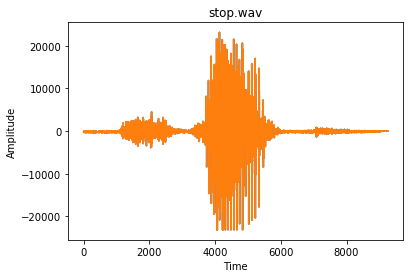

In [55]:
draw_file(filename)

In [56]:
max_time = get_time(audio_data, rate)
print("rate", rate)
print("max_time", max_time)

rate 11025
max_time 0.8401814058956916


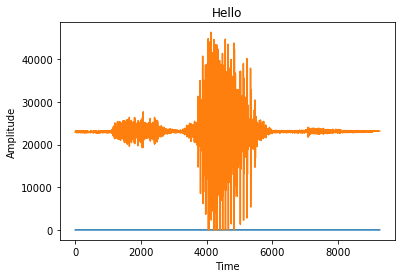

In [57]:
draw_data(audio_data)

In [77]:
i = 20
while i <= 20000:
    print(i, get_freq_magnitude(0, max_time, audio_data, i))
    i += 100


20 19357.261329502362
120 19411.911346121327
220 19413.00916480312
320 19413.254362855783
420 19413.346557145695
520 19413.390907219244
620 19413.415589597684
720 19413.430722733072
820 19413.440665349357
920 19413.447545828145
1020 19413.452503737535
1120 19413.45619394081
1220 19413.45901448621
1320 19413.46121862622
1420 19413.46297371479
1520 19413.464393937687
1620 19413.46555936581
1720 19413.466527493452
1820 19413.467340467465
1920 19413.4680297534
2020 19413.46861922675
2120 19413.469127268017
2220 19413.469568213786
2320 19413.46995337892
2420 19413.470291790145
2520 19413.47059071928
2620 19413.47085607758
2720 19413.471092709875
2820 19413.471304617604
2920 19413.47149512905
3020 19413.47166703059
3120 19413.47182266968
3220 19413.47196403458
3320 19413.472092818916
3420 19413.47221047234
3520 19413.472318241667
3620 19413.472417203753
3720 19413.472508292805
3820 19413.472592322283
3920 19413.472670003415
4020 19413.47274195985
4120 19413.472808740502
4220 19413.4728708302

[489.17227359190315,
 112.90925534733265,
 68.142436999067712,
 49.039983803064565,
 38.35156790224228,
 31.503593635990658,
 26.736478500370122,
 23.225109076607904,
 20.530319858579954,
 18.396593135001424,
 16.665054461599098,
 15.23169069916873,
 14.025534660038513,
 12.99649895425093,
 12.10821895884671,
 11.333652173339608,
 10.652269657686398,
 10.048205533819928,
 9.509003651473531,
 9.0247480017431148,
 8.5874464182420223,
 8.1905854577306716,
 7.8288034316971231,
 7.4976465425699779,
 7.1933844780917084,
 6.9128692078754259,
 6.6534256154059142,
 6.4127658933619163,
 6.188921887869073,
 5.9801911485217252,
 5.785093550120715,
 5.6023361453175102,
 5.4307844816285309,
 5.269439036756169,
 5.1174157372744276,
 4.9739297582209012,
 4.8382819764668374,
 4.7098475841108707,
 4.5880664704281111,
 4.4724350599526757,
 4.3624993558019707,
 4.2578489855742401,
 4.1581120851901332,
 4.0629508862393777,
 3.9720578964944804,
 3.8851525825994688,
 3.8019784795533274,
 3.7223006642689431,
